In [1]:
import os
import numpy as np
import imageio
import scipy
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from PIL import Image
from itertools import product
from sklearn.metrics import confusion_matrix, classification_report, sk_metrics, accuracy_score
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten


2023-08-24 10:49:58.861044: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
TRAIN_DIR = '/Users/allaartukevic/arina/photo2ingredient/models/kaggle/kaggle_dataset_2/train'
TEST_DIR = '/Users/allaartukevic/arina/photo2ingredient/models/kaggle/kaggle_dataset_2/test'
VALIDATION_DIR = '/Users/allaartukevic/arina/photo2ingredient/models/kaggle/kaggle_dataset_2/validation'

batch_size = 32
class_size = 34
img_size = 224


### Dataset balanced

In [ ]:
def count_images_in_subfolders(folder_path: str):
    subfolder_counts = {} 

    for subdir, _, files in os.walk(folder_path):
        image_count = len([file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))])
        subfolder_name = os.path.relpath(subdir, folder_path)
        subfolder_counts[subfolder_name] = image_count

    return subfolder_counts

def visualize_image_counts(folder_path: str):
    subfolder_counts = count_images_in_subfolders(folder_path)

    subfolder_names = list(subfolder_counts.keys())
    image_counts = list(subfolder_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(subfolder_names, image_counts)
    plt.xlabel('Subfolders')
    plt.ylabel('Number of Images')
    plt.title(f'Number of Images in Each Subfolder - {os.path.basename(folder_path)}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.show()

dataset_folders = [
    '/Users/allaartukevic/arina/photo2ingredient/models/kaggle/kaggle_dataset/test',
    '/Users/allaartukevic/arina/photo2ingredient/models/kaggle/kaggle_dataset/train'
]

for folder in dataset_folders:
    visualize_image_counts(folder)

### Model based on MobileNet

In [3]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (img_size, img_size, 3), include_top = False, weights = 'imagenet')

In [8]:
inputs_layer = tf.keras.Input(shape=(img_size, img_size, 3))
x = base_model(inputs_layer)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)

outputs_layer = tf.keras.layers.Dense(units=class_size, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs_layer, outputs=outputs_layer, name="photo2ingredients")

In [9]:

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

# Data normalization for validation images
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(img_size, img_size),
    batch_size=20,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(img_size, img_size),
    batch_size=10,
    class_mode='categorical',
    subset='validation')

train_filenames_res = train_generator.filenames
steps_train_res = len(train_filenames_res)/train_generator.batch_size

validation_filenames_res = validation_generator.filenames
steps_valid_res = len(validation_filenames_res)/validation_generator.batch_size


print(len(validation_filenames_res), " ", steps_valid_res)

model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

model_fit_generator = model.fit_generator(
        train_generator,
        steps_per_epoch=steps_train_res,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=steps_valid_res)

Found 2035 images belonging to 34 classes.
Found 492 images belonging to 34 classes.
492   49.2


/var/folders/95/5zmyhkdn171gn97b20t4hn0r0000gn/T/ipykernel_2337/4198682666.py:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_fit_generator = model.fit_generator(


Epoch 1/30
101/101 [==============================] - 339s 3s/step - loss: 2.3634 - accuracy: 0.4098 - val_loss: 1.2076 - val_accuracy: 0.6138
Epoch 2/30
101/101 [==============================] - 319s 3s/step - loss: 0.9245 - accuracy: 0.7322 - val_loss: 0.8944 - val_accuracy: 0.7012
Epoch 3/30
101/101 [==============================] - 315s 3s/step - loss: 0.6061 - accuracy: 0.8093 - val_loss: 0.7293 - val_accuracy: 0.7459
Epoch 4/30
101/101 [==============================] - 320s 3s/step - loss: 0.4305 - accuracy: 0.8678 - val_loss: 0.7587 - val_accuracy: 0.7602
Epoch 5/30
101/101 [==============================] - 319s 3s/step - loss: 0.3894 - accuracy: 0.8668 - val_loss: 0.7204 - val_accuracy: 0.7785
Epoch 6/30
101/101 [==============================] - 318s 3s/step - loss: 0.2924 - accuracy: 0.9042 - val_loss: 0.6313 - val_accuracy: 0.7967
Epoch 7/30
101/101 [==============================] - 319s 3s/step - loss: 0.2509 - accuracy: 0.9258 - val_loss: 0.5700 - val_accuracy: 0.8232

### Checking Results

/var/folders/95/5zmyhkdn171gn97b20t4hn0r0000gn/T/ipykernel_2337/625814597.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
/var/folders/95/5zmyhkdn171gn97b20t4hn0r0000gn/T/ipykernel_2337/625814597.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')


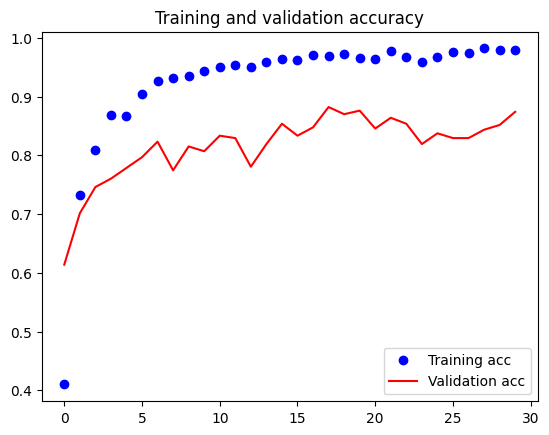

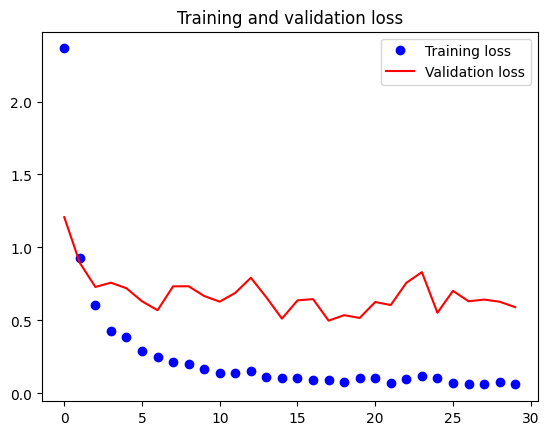

In [12]:
import matplotlib.pyplot as plt

acc = model_fit_generator.history['accuracy']
val_acc = model_fit_generator.history['val_accuracy']
loss = model_fit_generator.history['loss']
val_loss = model_fit_generator.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
resnet_train_testing_datagen = ImageDataGenerator(rescale=1./255)

resnet_train_testing_generator = resnet_train_testing_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(img_size, img_size),
        batch_size=1,
        shuffle = False,
        class_mode='categorical')

filenames = resnet_train_testing_generator.filenames
nb_samples = len(filenames)
res_predict = model.predict_generator(resnet_train_testing_generator,steps = nb_samples, verbose=2)

Found 2527 images belonging to 34 classes.


/var/folders/95/5zmyhkdn171gn97b20t4hn0r0000gn/T/ipykernel_2337/1461281131.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  res_predict = model.predict_generator(resnet_train_testing_generator,steps = nb_samples, verbose=2)


2527/2527 - 241s - 241s/epoch - 95ms/step


In [15]:
r_y_true_train = resnet_train_testing_generator.classes
r_y_pred_train= res_predict.argmax(axis=1)
train_confusion_mtx = confusion_matrix(r_y_true_train, r_y_pred_train)
train_classification_rep = classification_report(r_y_true_train, r_y_pred_train)
print("Train Confusion Matrix:")
print(train_confusion_mtx)
print("\nTrain Classification Report:")
print(train_classification_rep)

Train Confusion Matrix:
[[52  0  0 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  0 86 ...  0  0  0]
 ...
 [ 0  0  0 ... 78  0  0]
 [ 0  0  0 ...  0 82  0]
 [ 0  0  0 ...  0  0 74]]

Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        55
           1       1.00      0.95      0.97        60
           2       0.97      1.00      0.98        86
           3       0.96      1.00      0.98        79
           4       1.00      1.00      1.00        83
           5       0.97      1.00      0.99        72
           6       1.00      1.00      1.00        70
           7       0.95      0.74      0.83        73
           8       1.00      0.99      0.99        81
           9       1.00      0.99      0.99        72
          10       1.00      0.95      0.97        77
          11       1.00      1.00      1.00        59
          12       0.98      1.00      0.99        89
          13       0.97      0.92

In [16]:
cm_train = confusion_matrix(r_y_pred_train, r_y_true_train)

class_accuracies_train = np.diag(cm_train) / cm_train.sum(axis=1)

for i, accuracy in enumerate(class_accuracies_train):
    print(f"Accuracy for class {i}: {accuracy:.4f}")

Accuracy for class 0: 1.0000
Accuracy for class 1: 1.0000
Accuracy for class 2: 0.9663
Accuracy for class 3: 0.9634
Accuracy for class 4: 1.0000
Accuracy for class 5: 0.9730
Accuracy for class 6: 1.0000
Accuracy for class 7: 0.9474
Accuracy for class 8: 1.0000
Accuracy for class 9: 1.0000
Accuracy for class 10: 1.0000
Accuracy for class 11: 1.0000
Accuracy for class 12: 0.9780
Accuracy for class 13: 0.9730
Accuracy for class 14: 1.0000
Accuracy for class 15: 0.9000
Accuracy for class 16: 0.9765
Accuracy for class 17: 0.8734
Accuracy for class 18: 0.9375
Accuracy for class 19: 0.9615
Accuracy for class 20: 0.9324
Accuracy for class 21: 1.0000
Accuracy for class 22: 0.9886
Accuracy for class 23: 0.9487
Accuracy for class 24: 0.9710
Accuracy for class 25: 1.0000
Accuracy for class 26: 1.0000
Accuracy for class 27: 0.9655
Accuracy for class 28: 0.9545
Accuracy for class 29: 0.9762
Accuracy for class 30: 0.8152
Accuracy for class 31: 0.9750
Accuracy for class 32: 0.9647
Accuracy for class 3

In [17]:
resnet_test_datagen = ImageDataGenerator(rescale=1./255)

resnet_test_generator = resnet_test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(img_size, img_size),
        batch_size=1,
        shuffle = False,
        class_mode='categorical')

filenames = resnet_test_generator.filenames
nb_samples = len(filenames)
#nb_samples


Found 216 images belonging to 34 classes.


In [18]:
res_predict_test = model.predict_generator(resnet_test_generator,steps = nb_samples, verbose=2)
r_y_true = resnet_test_generator.classes
r_y_pred = res_predict_test.argmax(axis=1)

test_confusion_mtx = confusion_matrix(r_y_true, r_y_pred)
test_classification_rep = classification_report(r_y_true, r_y_pred)
print("\nTest Confusion Matrix:")
print(test_confusion_mtx)
print("\nTest Classification Report:")
print(test_classification_rep)

/var/folders/95/5zmyhkdn171gn97b20t4hn0r0000gn/T/ipykernel_2337/611643649.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  res_predict_test = model.predict_generator(resnet_test_generator,steps = nb_samples, verbose=2)


216/216 - 18s - 18s/epoch - 84ms/step

Test Confusion Matrix:
[[0 0 0 ... 1 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 7 ... 0 0 0]
 ...
 [0 0 0 ... 7 0 0]
 [0 0 0 ... 0 6 0]
 [0 0 0 ... 0 0 6]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       1.00      1.00      1.00         5
           2       0.88      1.00      0.93         7
           3       1.00      0.83      0.91         6
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         6
           6       1.00      0.75      0.86         4
           7       0.67      0.40      0.50         5
           8       0.75      1.00      0.86         6
           9       1.00      0.86      0.92         7
          10       1.00      0.40      0.57         5
          11       0.86      1.00      0.92         6
          12       0.78      1.00      0.88         7
          13       1.00      0.6

/Users/allaartukevic/miniconda3/envs/project_food/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/allaartukevic/miniconda3/envs/project_food/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/allaartukevic/miniconda3/envs/project_food/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [19]:
cm = confusion_matrix(r_y_pred, r_y_true)

class_accuracies = np.diag(cm) / cm.sum(axis=1)

for i, accuracy in enumerate(class_accuracies):
    print(f"Accuracy for class {i}: {accuracy:.4f}")

Accuracy for class 0: nan
Accuracy for class 1: 1.0000
Accuracy for class 2: 0.8750
Accuracy for class 3: 1.0000
Accuracy for class 4: 1.0000
Accuracy for class 5: 1.0000
Accuracy for class 6: 1.0000
Accuracy for class 7: 0.6667
Accuracy for class 8: 0.7500
Accuracy for class 9: 1.0000
Accuracy for class 10: 1.0000
Accuracy for class 11: 0.8571
Accuracy for class 12: 0.7778
Accuracy for class 13: 1.0000
Accuracy for class 14: 1.0000
Accuracy for class 15: 0.6000
Accuracy for class 16: 1.0000
Accuracy for class 17: 0.6667
Accuracy for class 18: 0.7000
Accuracy for class 19: 0.6667
Accuracy for class 20: 0.7500
Accuracy for class 21: 1.0000
Accuracy for class 22: 1.0000
Accuracy for class 23: 0.6667
Accuracy for class 24: 0.7143
Accuracy for class 25: 1.0000
Accuracy for class 26: 0.8750
Accuracy for class 27: 0.8750
Accuracy for class 28: 0.8333
Accuracy for class 29: 1.0000
Accuracy for class 30: 0.6667
Accuracy for class 31: 0.7000
Accuracy for class 32: 0.7500
Accuracy for class 33: 

/var/folders/95/5zmyhkdn171gn97b20t4hn0r0000gn/T/ipykernel_2337/1929772960.py:3: RuntimeWarning: invalid value encountered in divide
  class_accuracies = np.diag(cm) / cm.sum(axis=1)


### Model based on VGG16

In [102]:
vgg_model = VGG16(include_top=False,
                  input_shape = (img_size, img_size, 3),
                  weights = 'imagenet')

In [103]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [105]:
for layer in vgg_model.layers:
    layer.trainable = False
    
for layer in vgg_model.layers:
    print(layer,layer.trainable)

vgg_transfer_base_model = Sequential()
vgg_transfer_base_model.add(vgg_model)
vgg_transfer_base_model.add(GlobalAveragePooling2D())
vgg_transfer_base_model.add(Dense(class_size, activation='softmax'))
vgg_transfer_base_model.summary()


<keras.src.engine.input_layer.InputLayer object at 0x7f91dd8d1e40> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f91be893ee0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f91fe8b3b20> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f91dd8d2380> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f91fe8b09d0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f91be891870> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f91be8820e0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f91fd2b5630> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f91be882950> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f91be891090> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f91be883d90> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f91be881780> False
<keras.src.layers.convolutional.conv2d.Conv2D ob

In [106]:
vgg_train_datagen_do = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

vgg_train_generator_do = vgg_train_datagen_do.flow_from_directory(
    TRAIN_DIR,
    target_size=(img_size, img_size),
    batch_size=20,
    class_mode='categorical',
    subset='training')

vgg_validation_generator_do = vgg_train_datagen_do.flow_from_directory(
    TRAIN_DIR,
    target_size=(img_size, img_size),
    batch_size=10,
    class_mode='categorical',
    subset='validation')
    

vgg_transfer_base_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])


train_filenames_do = vgg_train_generator_do.filenames
steps_train_do = len(train_filenames_do)/vgg_train_generator_do.batch_size


validation_filenames_do = vgg_validation_generator_do.filenames
steps_valid_do = len(validation_filenames_do)/vgg_validation_generator_do.batch_size


vgg_base_fit_generator_do = vgg_transfer_base_model.fit_generator(
        vgg_train_generator_do,
        steps_per_epoch=steps_train_do,
        epochs=50,
        validation_data=vgg_validation_generator_do,
        validation_steps=steps_valid_do,
        verbose=1)

Found 2035 images belonging to 34 classes.
Found 492 images belonging to 34 classes.


/var/folders/95/5zmyhkdn171gn97b20t4hn0r0000gn/T/ipykernel_3552/192648376.py:43: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vgg_base_fit_generator_do = vgg_transfer_base_model.fit_generator(


Epoch 1/50
101/101 [==============================] - 406s 4s/step - loss: 3.4444 - acc: 0.0899 - val_loss: 3.2202 - val_acc: 0.2053
Epoch 2/50
101/101 [==============================] - 395s 4s/step - loss: 3.1439 - acc: 0.2143 - val_loss: 2.9517 - val_acc: 0.3394
Epoch 3/50
101/101 [==============================] - 398s 4s/step - loss: 2.9188 - acc: 0.3224 - val_loss: 2.7173 - val_acc: 0.3923
Epoch 4/50
101/101 [==============================] - 403s 4s/step - loss: 2.7337 - acc: 0.3656 - val_loss: 2.5586 - val_acc: 0.4390
Epoch 5/50
101/101 [==============================] - 404s 4s/step - loss: 2.5873 - acc: 0.4187 - val_loss: 2.3798 - val_acc: 0.4715
Epoch 6/50
101/101 [==============================] - 406s 4s/step - loss: 2.4494 - acc: 0.4452 - val_loss: 2.2607 - val_acc: 0.5081
Epoch 7/50
101/101 [==============================] - 407s 4s/step - loss: 2.3421 - acc: 0.4644 - val_loss: 2.1781 - val_acc: 0.5325
Epoch 8/50
101/101 [==============================] - 409s 4s/step - 

/var/folders/95/5zmyhkdn171gn97b20t4hn0r0000gn/T/ipykernel_3552/504601785.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
/var/folders/95/5zmyhkdn171gn97b20t4hn0r0000gn/T/ipykernel_3552/504601785.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')


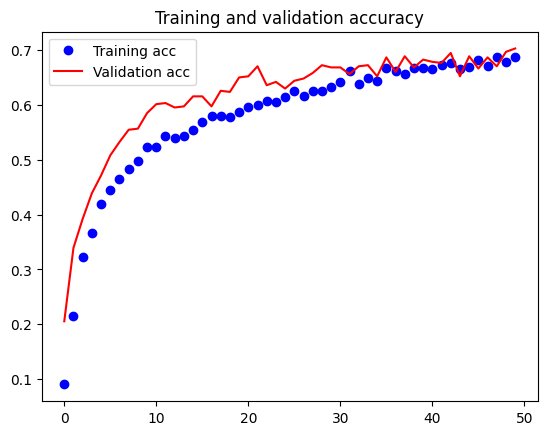

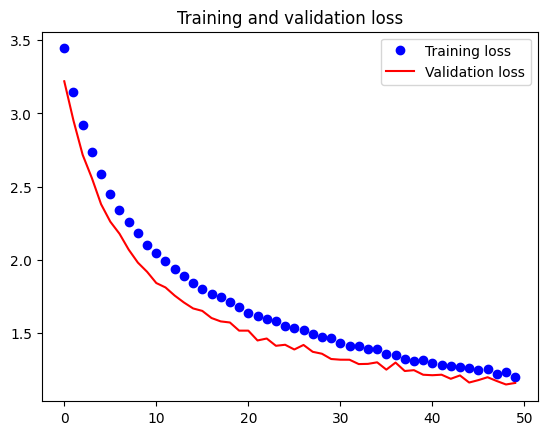

In [109]:
acc = vgg_base_fit_generator_do.history['acc']
val_acc = vgg_base_fit_generator_do.history['val_acc']
loss = vgg_base_fit_generator_do.history['loss']
val_loss = vgg_base_fit_generator_do.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Checking results

In [110]:
resnet_test_datagen = ImageDataGenerator(rescale=1./255)

resnet_test_generator = resnet_test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(img_size, img_size),
        batch_size=1,
        shuffle = False,
        class_mode='categorical')

filenames = resnet_test_generator.filenames
nb_samples = len(filenames)

res_predict_test = vgg_transfer_base_model.predict_generator(resnet_test_generator,steps = nb_samples, verbose=2)
r_y_true = resnet_test_generator.classes
r_y_pred = res_predict_test.argmax(axis=1)
test_confusion_mtx = confusion_matrix(r_y_true, r_y_pred)
test_classification_rep = classification_report(r_y_true, r_y_pred)
print("\nTest Confusion Matrix:")
print(test_confusion_mtx)
print("\nTest Classification Report:")
print(test_classification_rep)

cm = confusion_matrix(r_y_pred, r_y_true)

class_accuracies = np.diag(cm) / cm.sum(axis=1)

for i, accuracy in enumerate(class_accuracies):
    print(f"Accuracy for class {i}: {accuracy:.4f}")

Found 216 images belonging to 34 classes.


/var/folders/95/5zmyhkdn171gn97b20t4hn0r0000gn/T/ipykernel_3552/4212230918.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  res_predict_test = vgg_transfer_base_model.predict_generator(resnet_test_generator,steps = nb_samples, verbose=2)


216/216 - 38s - 38s/epoch - 175ms/step

Test Confusion Matrix:
[[1 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 7 ... 0 0 0]
 ...
 [1 0 0 ... 6 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 6]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.25      0.29         4
           1       1.00      1.00      1.00         5
           2       0.88      1.00      0.93         7
           3       0.45      0.83      0.59         6
           4       0.88      0.88      0.88         8
           5       1.00      0.83      0.91         6
           6       1.00      1.00      1.00         4
           7       0.57      0.80      0.67         5
           8       0.71      0.83      0.77         6
           9       0.60      0.43      0.50         7
          10       0.75      0.60      0.67         5
          11       1.00      0.83      0.91         6
          12       0.86      0.86      0.86         7
          13       0.67      0.

In [111]:
resnet_train_testing_datagen = ImageDataGenerator(rescale=1./255)

resnet_train_testing_generator = resnet_train_testing_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(img_size, img_size),
        batch_size=1,
        shuffle = False,
        class_mode='categorical')

filenames = resnet_train_testing_generator.filenames
nb_samples = len(filenames)

res_predict = vgg_transfer_base_model.predict_generator(resnet_train_testing_generator,steps = nb_samples, verbose=2)

r_y_true_train = resnet_train_testing_generator.classes
r_y_pred_train= res_predict.argmax(axis=1)
train_confusion_mtx = confusion_matrix(r_y_true_train, r_y_pred_train)
train_classification_rep = classification_report(r_y_true_train, r_y_pred_train)
print("Train Confusion Matrix:")
print(train_confusion_mtx)
print("\nTrain Classification Report:")
print(train_classification_rep)

cm = confusion_matrix(r_y_pred_train, r_y_true_train)

class_accuracies = np.diag(cm) / cm.sum(axis=1)

for i, accuracy in enumerate(class_accuracies):
    print(f"Accuracy for class {i}: {accuracy:.4f}")

Found 2527 images belonging to 34 classes.


/var/folders/95/5zmyhkdn171gn97b20t4hn0r0000gn/T/ipykernel_3552/113521367.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  res_predict = vgg_transfer_base_model.predict_generator(resnet_train_testing_generator,steps = nb_samples, verbose=2)


2527/2527 - 376s - 376s/epoch - 149ms/step
Train Confusion Matrix:
[[34  0  0 ...  4  0  1]
 [ 0 43  0 ...  0  0  2]
 [ 0  1 55 ...  0  0  0]
 ...
 [ 3  0  0 ... 66  0  0]
 [ 1  0  0 ...  1 45  1]
 [ 0  0  2 ...  0  0 61]]

Train Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.62      0.69        55
           1       0.93      0.72      0.81        60
           2       0.80      0.64      0.71        86
           3       0.57      0.75      0.64        79
           4       0.90      0.78      0.84        83
           5       0.83      0.74      0.78        72
           6       0.79      0.86      0.82        70
           7       0.71      0.60      0.65        73
           8       0.90      0.69      0.78        81
           9       0.69      0.61      0.65        72
          10       0.70      0.83      0.76        77
          11       0.85      0.80      0.82        59
          12       0.68      0.96      0.79 